In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.n_jobs = 8
%config InlineBackend.figure_format = 'retina'

In [2]:
meta = pd.read_csv('test_data/cell_state.csv', index_col=0)
meta.index = [f'cell_{i}' for i in range(1, 1500+1)]
meta.columns = ['state']

In [3]:
n_tr=500
n_st=1000

In [4]:
transit = pd.read_csv('./test_data/transit.csv', index_col=0)
transit.columns = [f'cell_{i}' for i in range(1, 1500+1)]
transit.index = [f'gene-{i}' for i in range(1, 100+1)]

In [5]:
adata_tr = sc.AnnData(transit.T)
adata_tr.obs['bin'] = np.repeat([1,2,3], n_tr)
adata_tr.obs['state'] = meta

In [6]:
stable = pd.read_csv('./test_data/stable.csv', index_col=0)
stable.columns = [f'cell_{i}' for i in range((1+transit.shape[1]), 1+(transit.shape[1]+stable.shape[1]))]

In [7]:
adata_st = sc.AnnData(stable.T)
adata_st.obs['bin'] = np.repeat([1,2,3], n_st)
adata_st.obs['state'] = 'stable'

In [8]:
adata = sc.concat([adata_tr, adata_st])
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obsm['X_pca'] = sc.pp.pca(sc.pp.scale(adata.X.copy()))
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)

/Users/pax/miniconda3/envs/scTCI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_98215/1291030218.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


In [9]:
keep = adata.obs.leiden.value_counts().loc[lambda x: x>100].index
adata = adata[adata.obs.leiden.isin(keep)]

/Users/pax/miniconda3/envs/scTCI/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


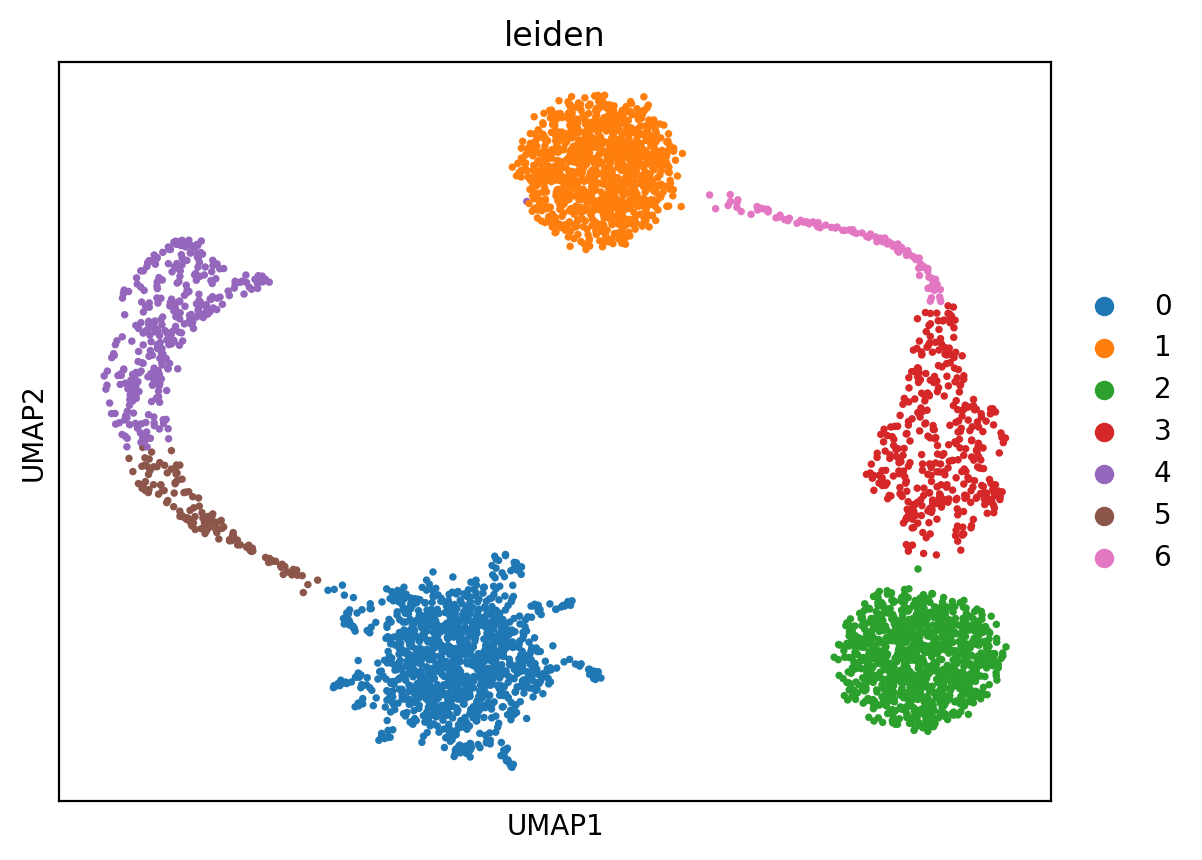

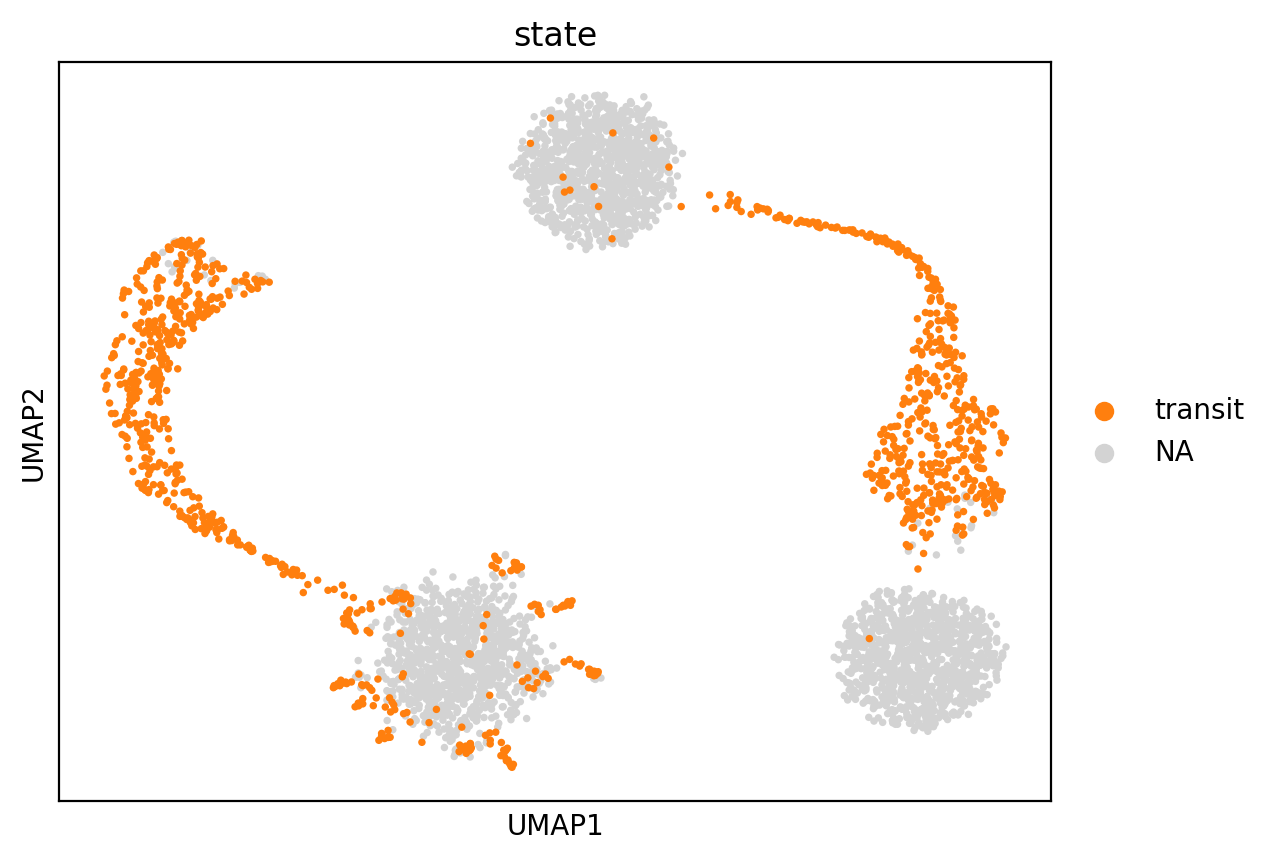

In [10]:
sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color=['state'], groups=['transit'])

In [11]:
import scTCIpy as stpy

In [ ]:
# calculate the transition index
stpy.transition_index(adata, ncores=None, n_neighbors=100)

Processing: 0


100%|██████████| 1176/1176 [00:32<00:00, 36.35it/s]


Processing: 1


100%|██████████| 1012/1012 [00:28<00:00, 35.83it/s]


Processing: 2


100%|██████████| 1004/1004 [00:26<00:00, 37.64it/s]


Processing: 3


100%|██████████| 381/381 [00:10<00:00, 36.56it/s]


Processing: 4


100%|██████████| 338/338 [00:09<00:00, 36.29it/s]


Processing: 5


100%|██████████| 130/130 [00:03<00:00, 36.88it/s]


Processing: 6


100%|██████████| 103/103 [00:02<00:00, 37.95it/s]


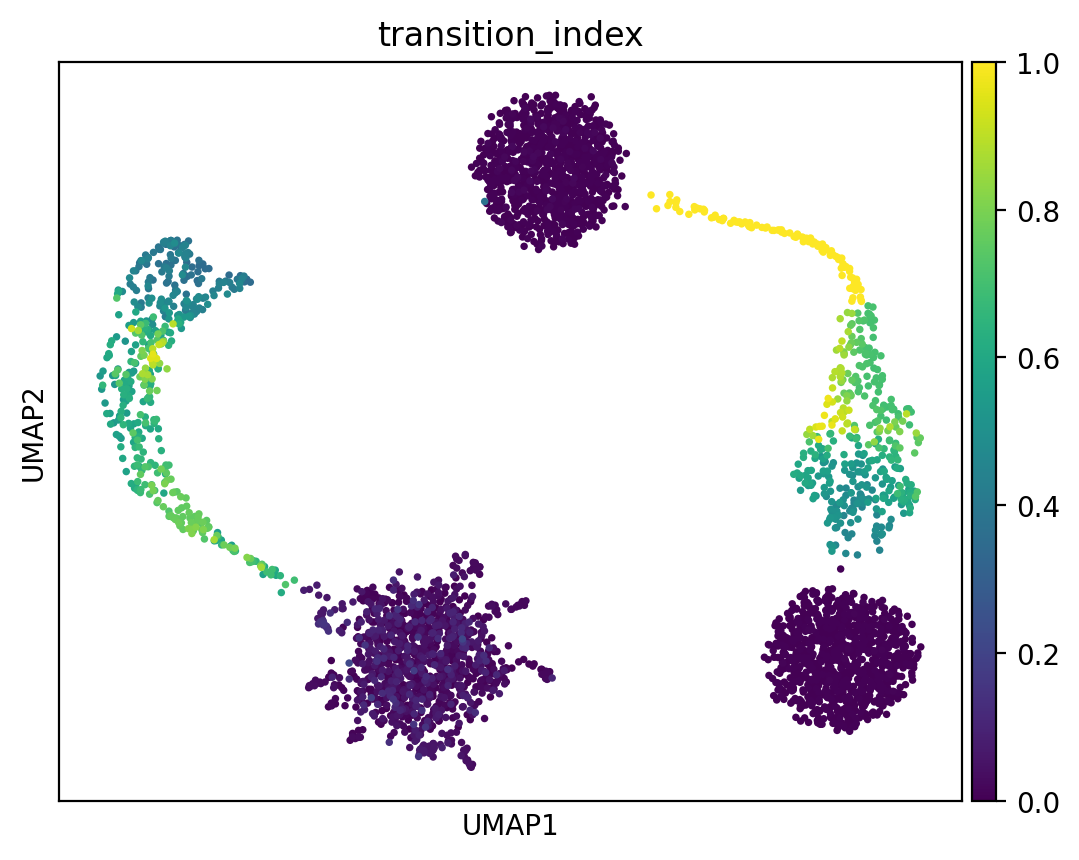

<Axes: ylabel='Frequency'>

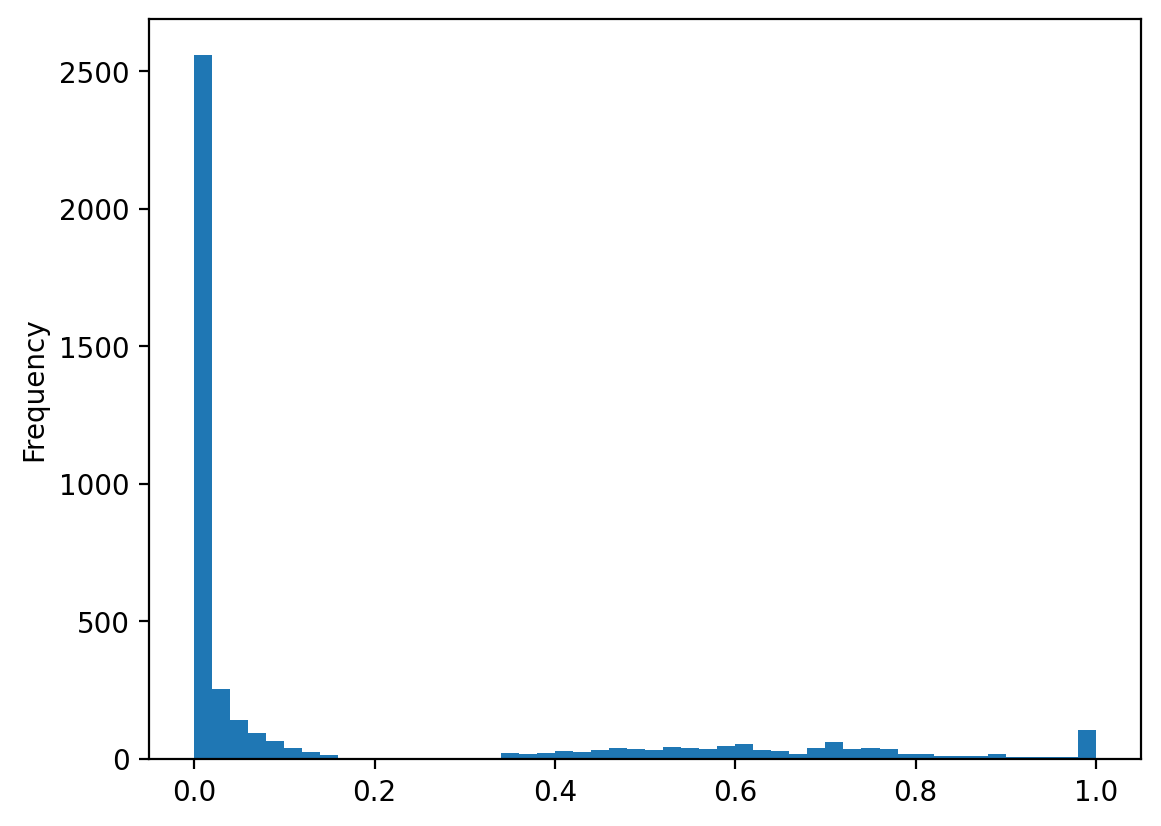

In [13]:
sc.pl.umap(adata, color=['transition_index'])
adata.obs.transition_index.plot(kind='hist', bins=50)

<Axes: xlabel='transition_index', ylabel='Density'>

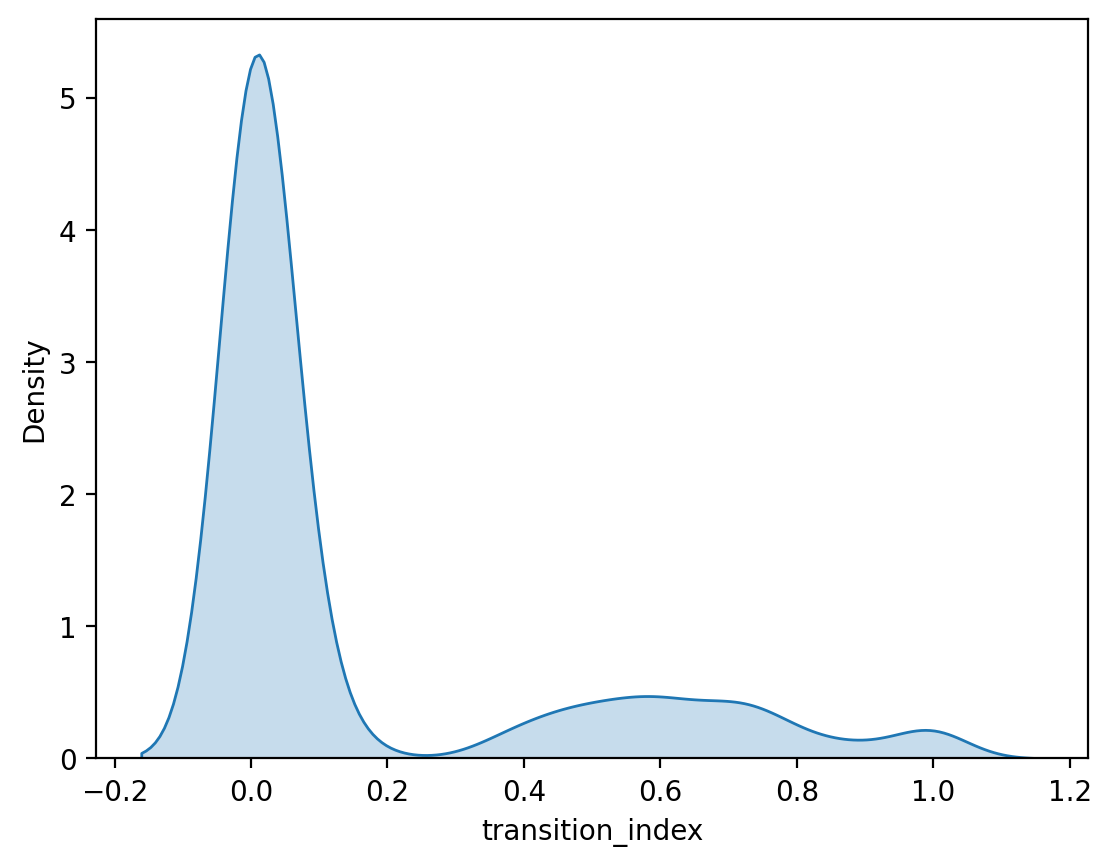

In [14]:
sns.kdeplot(adata.obs.transition_index, shade=True)

In [ ]:
# Cluster the transition cells using Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
x = adata.obs.transition_index.values.reshape(-1,1)
gmm = GaussianMixture(n_components=2).fit(x)

cluster = gmm.predict(x)
cluster_prob = gmm.predict_proba(x)

adata.obs['transition_cells'] = (cluster == 1) & (cluster_prob[:,-1] > 0.8)
adata.obs['transition_cells'] = adata.obs['transition_cells'].apply(lambda x: 'transition_cells' if x else 'stable')

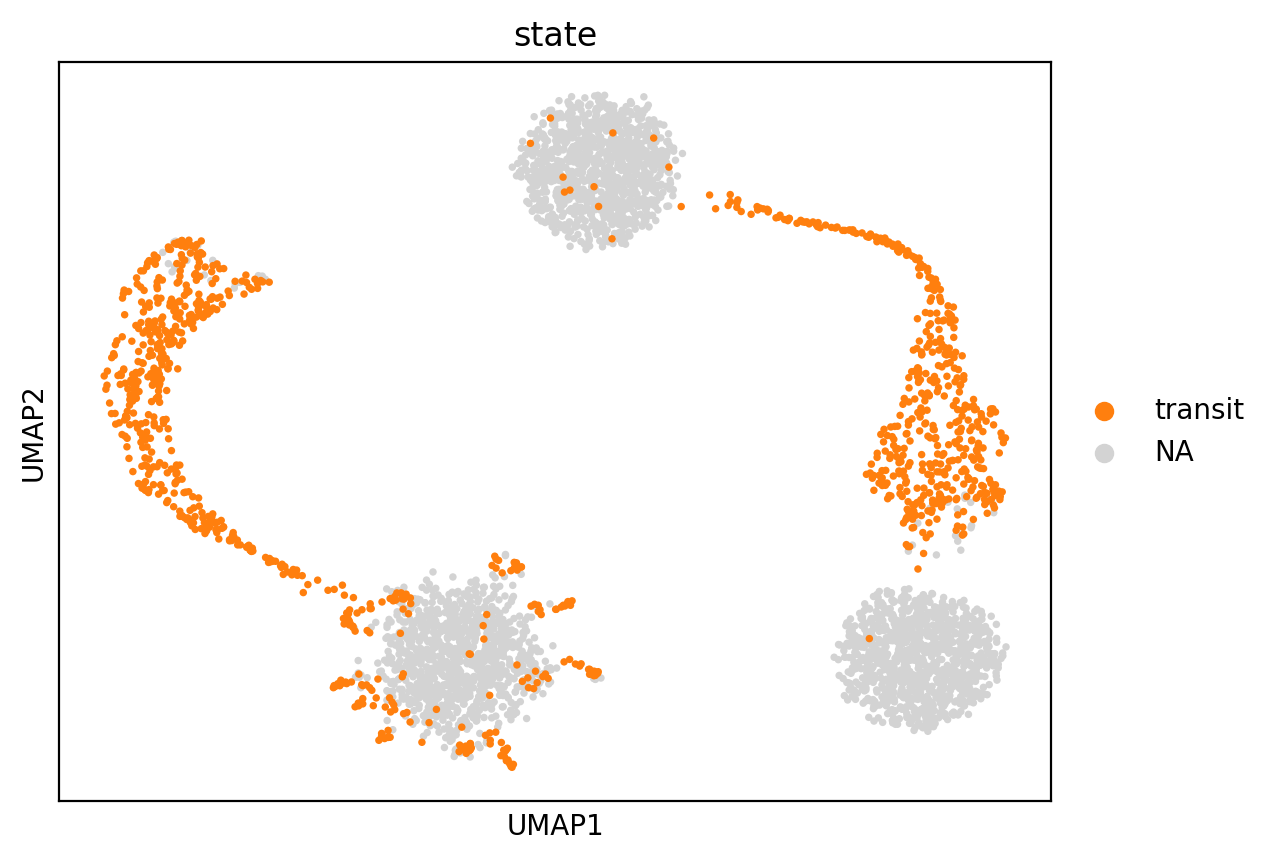

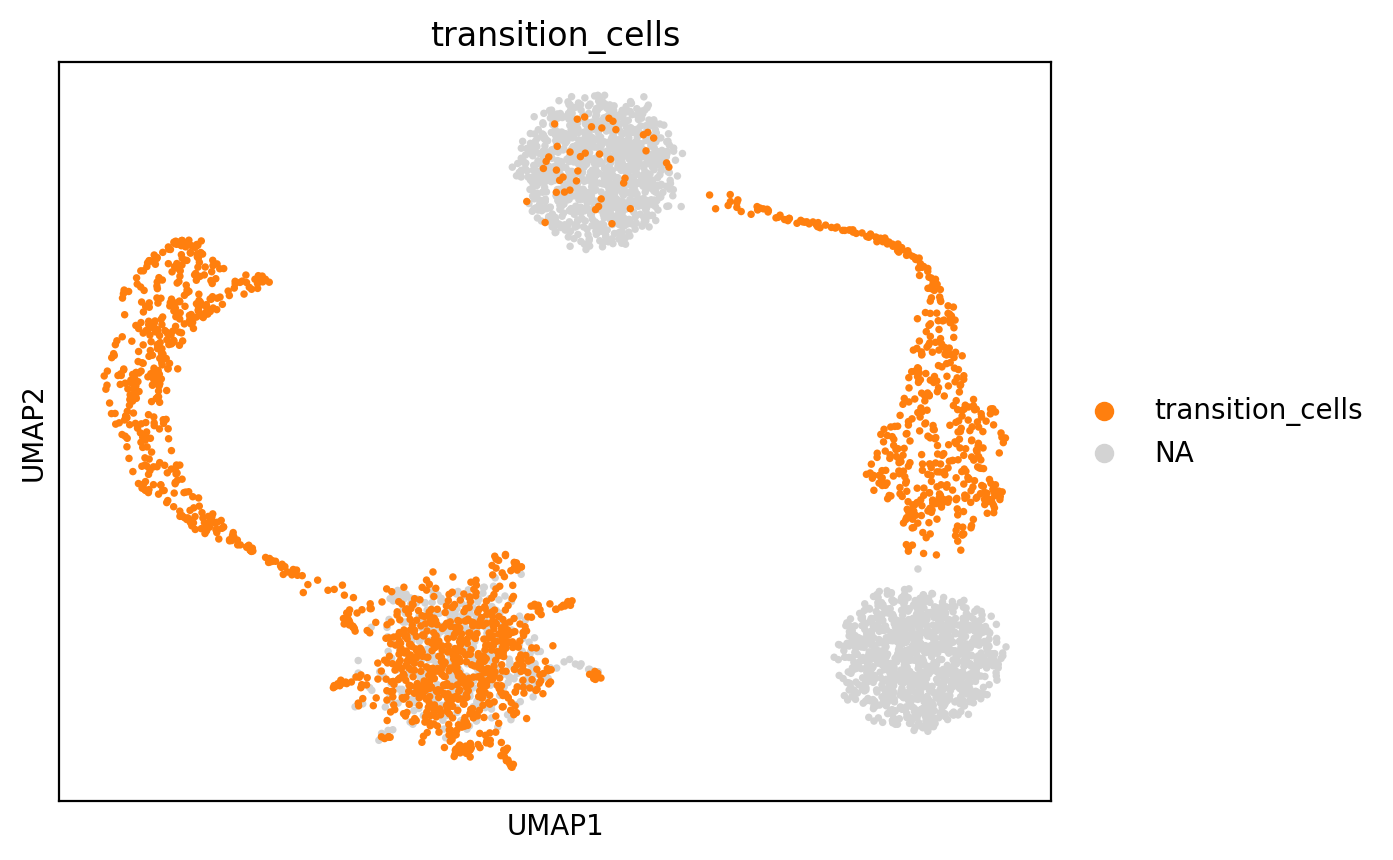

In [16]:
sc.pl.umap(adata, color=['state'], groups=['transit'])
sc.pl.umap(adata, color=['transition_cells'], groups=['transition_cells'])